In [1]:
import numpy as np
import rasterio as rs
import hickle as hkl
import os
import hickle as hkl
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd



In [2]:
x = pd.read_csv("../../src/processing_area_nov_10.csv")
x = x[x['country'] == 'Mexico']
x.reset_index(inplace = True)
x.to_csv("../../src/mexico.csv")

In [257]:
x = "../../src/features.npy"
x = np.load(x)

In [258]:
x.shape

(218, 218, 32)

<AxesSubplot:>

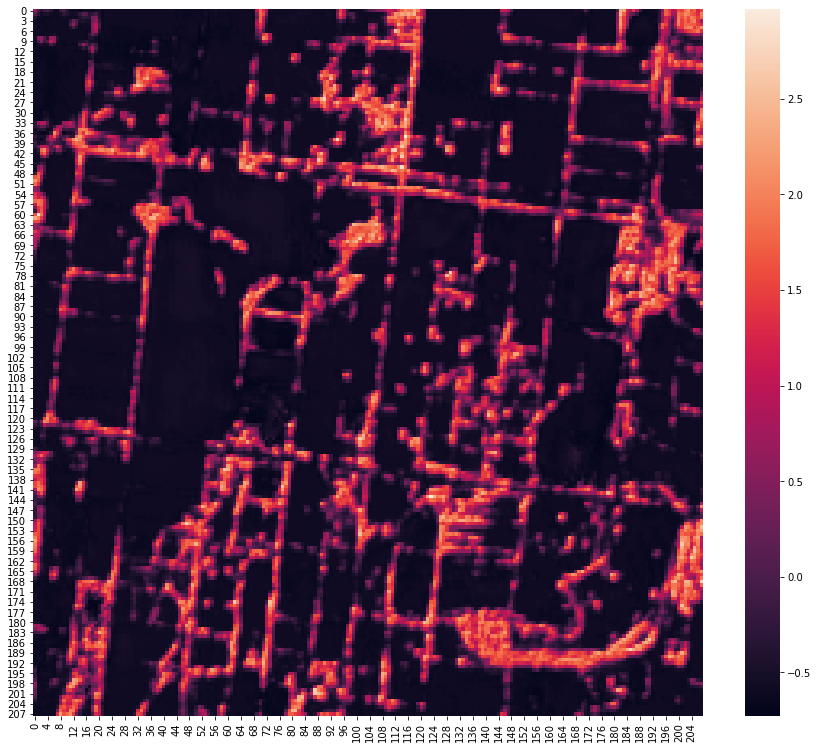

In [304]:
plt.figure(figsize=(15, 13))
sns.heatmap(x[5:-5, 5:-5, 14])

In [2]:

def fspecial_gauss(size: int, sigma: int) -> np.ndarray:
    """Function to mimic the 'fspecial' gaussian MATLAB function

        Parameters:
         size (int): size of square guassian kernel
         sigma (float): diameter of the kernel
    
        Returns:
         g (np.ndarray): gaussian kernel from [0, 1]
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

In [3]:
def recreate_resegmented_tifs(out_folder: str, shape) -> np.ndarray:
    """
    Loads the .npy subtile files in an output folder and mosaics the overlapping predictions
    to return a single .npy file of tree cover for the 6x6 km tile
    Additionally, applies post-processing threshold rules and implements no-data flag of 255
    
        Parameters:
         out_folder (os.Path): location of the prediction .npy files 
    
        Returns:
         predictions (np.ndarray): 6 x 6 km tree cover data as a uint8 from 0-100 w/ 255 no-data flag
    """
    from skimage.transform import resize
    print(f"Recreating: {out_folder}")
    n_up = len(glob(out_folder + "*/up*.npy"))
    n_down = len(glob(out_folder + "*/down*.npy"))
    n_left = len(glob(out_folder + "*/left*.npy"))
    n_right = len(glob(out_folder + "right*/*.npy"))

    right = [x for x in os.listdir(out_folder) if 'right' in x]
                      
    x_tiles = [x for x in os.listdir(out_folder) if 'right' not in x]
    x_tiles = [x for x in x_tiles if '.DS' not in x]
    x_tiles = [x for x in x_tiles if len(os.listdir(out_folder + "/" + x)) > 0]
    x_tiles = [int(x) for x in x_tiles]

    max_x = np.max(x_tiles) + SIZE
    for x_tile in x_tiles:
        y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        y_tiles = [y for y in y_tiles if 'left' not in y]
        y_tiles = [y for y in y_tiles if 'down' not in y]
        y_tiles = [int(y[:-4]) for y in y_tiles if 'up' not in y]
        
    n_tiles = len(glob(out_folder + "*/*.npy"))
    n_border = n_up + n_down + n_left + n_right
    predictions = np.full((shape[1], shape[0], n_tiles), np.nan, dtype = np.float32)
    mults = np.full((shape[1], shape[0], n_tiles), 0, dtype = np.float32)
    print(predictions.shape)
    i = 0

    for x_tile in x_tiles:
        y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        y_tiles = [y for y in y_tiles if 'left' not in y]
        y_tiles = [y for y in y_tiles if 'down' not in y]
        y_tiles = [int(y[:-4]) for y in y_tiles if 'up' not in y]
        for y_tile in y_tiles:
            output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
            if os.path.exists(output_file):
                prediction = np.load(output_file)
                size_y = prediction.shape[0]
                size_x = prediction.shape[1]
                subtile_size = np.maximum(size_x, size_y)
                if np.sum(prediction) < size_x*size_y*255:
                    prediction = (prediction * 100).T.astype(np.float32)
                    if subtile_size == 208:
                        fspecial_size = 44
                    elif subtile_size == 348:
                        fspecial_size = 85
                    elif subtile_size == 412:
                        fspecial_size = 95
                    else:
                        fspecial_size = 28
                    if (x_tile + size_x - 1) < shape[1] and (y_tile + size_y- 1) < shape[0]:
                        predictions[x_tile: x_tile+size_x, y_tile:y_tile + size_y, i] = prediction
                        mults[x_tile: x_tile+size_x, y_tile:y_tile + size_y, i] = fspecial_gauss(subtile_size, fspecial_size)
                    else:
                        print(f"Skipping {x_tile, y_tile} because of {predictions.shape}")
                    i += 1
                
    # LEFT BLOCK
    if n_left > 0:
        for x_tile in x_tiles:
            y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
            y_tiles = [int(y[4:-4]) for y in y_tiles if 'left' in y]
            for y_tile in y_tiles:
                output_file = out_folder + str(x_tile) + "/left" + str(y_tile) + ".npy"
                if os.path.exists(output_file):
                    prediction = np.load(output_file)
                    size_y = prediction.shape[0]
                    size_x = prediction.shape[1] // 2
                    subtile_size = np.maximum(size_x * 2, size_y)
                    if subtile_size == 208:
                        fspecial_size = 44
                    elif subtile_size == 348:
                        fspecial_size = 85
                    elif subtile_size == 412:
                        fspecial_size = 95
                    elif subtile_size == 588:
                        fspecial_size = 150
                    else:
                        fspecial_size = 28
                    fspecial_i = fspecial_gauss(subtile_size, fspecial_size)[size_x:, :]
                    fspecial_i = resize(fspecial_i, (size_x, size_y), order = 1)
                    if np.sum(prediction) < size_x*size_y*255:
                        prediction = (prediction * 100).T.astype(np.float32)
                        prediction = prediction[size_x:, :]
                        print(prediction.shape)
                        predictions[x_tile: x_tile+size_x, y_tile:y_tile + size_y, i] = prediction
                        mults[x_tile: x_tile+ size_x, y_tile:y_tile + size_y, i] = fspecial_i
                    print(i)
                    i += 1
                    
    # RIGHT BLOCK
    if n_right > 0:
        for x_tile in right:
            x_tile_name = x_tile
            x_tile = int(x_tile[5:])
            y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile_name) + "/") if '.DS' not in y]
            for y_tile in y_tiles:
                output_file = out_folder + str(x_tile_name) + "/" + str(y_tile) + ".npy"
                if os.path.exists(output_file):
                    prediction = np.load(output_file)
                    print(prediction.shape)
                    size_y = prediction.shape[0]
                    size_x = prediction.shape[1] // 2
                    subtile_size = np.maximum(size_x * 2, size_y)
                    print(subtile_size)
                    if subtile_size == 208:
                        fspecial_size = 44
                    elif subtile_size == 348:
                        fspecial_size = 85
                    elif subtile_size == 412:
                        fspecial_size = 95
                    elif subtile_size == 588:
                        fspecial_size = 150
                    else:
                        fspecial_size = 28
                    fspecial_i = fspecial_gauss(subtile_size, fspecial_size)[:size_x, :]
                    fspecial_i = resize(fspecial_i, (size_x, size_y), order = 1)

                    if np.sum(prediction) < size_x*size_y*255:
                        prediction = (prediction * 100).T.astype(np.float32)
                        prediction = prediction[:size_x, :]
                        predictions[x_tile: x_tile+size_x, y_tile:y_tile + size_y, i] = prediction
                        mults[x_tile: x_tile+ size_x, y_tile:y_tile + size_y, i] = fspecial_i
                    print(i)
                    i += 1
                    
    if n_up > 0:
        for x_tile in x_tiles:
            y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
            y_tiles = [int(y[2:-4]) for y in y_tiles if 'up' in y]
            for y_tile in y_tiles:
                output_file = out_folder + str(x_tile) + "/up" + str(y_tile) + ".npy"
                if os.path.exists(output_file):
                    prediction = np.load(output_file)
                    size_y = prediction.shape[0] // 2
                    size_x = prediction.shape[1]
                    subtile_size = np.maximum(size_x, size_y * 2)
                    if subtile_size == 208:
                        fspecial_size = 44
                    elif subtile_size == 348:
                        fspecial_size = 85
                    elif subtile_size == 412:
                        fspecial_size = 95
                    elif subtile_size == 588:
                        fspecial_size = 150
                    else:
                        fspecial_size = 28
                    fspecial_i = fspecial_gauss(subtile_size, fspecial_size)[:, size_y:]
                    fspecial_i = resize(fspecial_i, (size_x, size_y), order = 1)
                    if np.sum(prediction) < size_x*size_y*255:
                        prediction = (prediction * 100).T.astype(np.float32)
                        prediction = prediction[:, size_y:]
                        predictions[x_tile: x_tile+size_x, y_tile:y_tile + size_y, i] = prediction
                        mults[x_tile: x_tile+ size_x, y_tile:y_tile + size_y, i] = fspecial_i
                    i += 1
                    
    if n_down > 0:
        for x_tile in x_tiles:
            y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
            y_tiles = [int(y[4:-4]) for y in y_tiles if 'down' in y]
            for y_tile in y_tiles:
                output_file = out_folder + str(x_tile) + "/down" + str(y_tile) + ".npy"
                if os.path.exists(output_file):
                    prediction = np.load(output_file)
                    size_y = prediction.shape[0] // 2
                    size_x = prediction.shape[1]
                    subtile_size = np.maximum(size_x, size_y * 2)
                    if subtile_size == 208:
                        fspecial_size = 44
                    elif subtile_size == 348:
                        fspecial_size = 85
                    elif subtile_size == 412:
                        fspecial_size = 95
                    elif subtile_size == 588:
                        fspecial_size = 150
                    else:
                        fspecial_size = 28
                    fspecial_i = fspecial_gauss(subtile_size, fspecial_size)[:, :size_y]
                    fspecial_i = resize(fspecial_i, (size_x, size_y), order = 1)
                    if np.sum(prediction) < size_x*size_y*255:
                        prediction = (prediction * 100).T.astype(np.float32)
                        prediction = prediction[:, :size_y]
                        predictions[x_tile: x_tile+size_x, y_tile:y_tile + size_y, i] = prediction
                        mults[x_tile: x_tile+ size_x, y_tile:y_tile + size_y, i] = fspecial_i
                    i += 1

    predictions = predictions.astype(np.float32)
    
    mults = mults / np.sum(mults, axis = -1)[..., np.newaxis]

    predictions[predictions > 100] = np.nan
    out = np.copy(predictions)
    out = np.sum(np.isnan(out), axis = (2))
    n_preds = predictions.shape[-1]
    predictions = np.nansum(predictions * mults, axis = -1)
    predictions[out == n_preds] = np.nan
    predictions[np.isnan(predictions)] = 255.
    predictions = predictions.astype(np.uint8)
                
    predictions[predictions <= .20*100] = 0.        
    predictions[predictions > 100] = 255.
    
    return predictions, mults

In [8]:
SIZE = 588
left, y = recreate_resegmented_tifs("../../project-monitoring/tiles/389/1269/processed/", (618, 592))

Recreating: ../../project-monitoring/tiles/389/1269/processed/
(592, 618, 39)
(294, 240)
36
(294, 240)
37
(294, 240)
38


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:203: RuntimeWarning: invalid value encountered in greater


<AxesSubplot:>

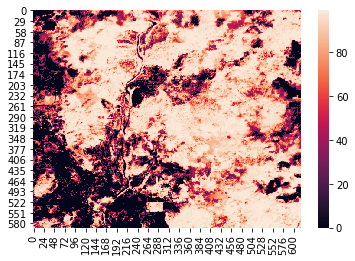

In [9]:
sns.heatmap(left)

In [11]:
SIZE = 588
right, yrright = recreate_resegmented_tifs("../../project-monitoring/tiles/388/1269/processed/", (618, 592))

Recreating: ../../project-monitoring/tiles/388/1269/processed/
(592, 618, 39)
(240, 588)
588
35
(240, 588)
588
36
(240, 588)
588
37


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in true_divide
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:203: RuntimeWarning: invalid value encountered in greater


<AxesSubplot:>

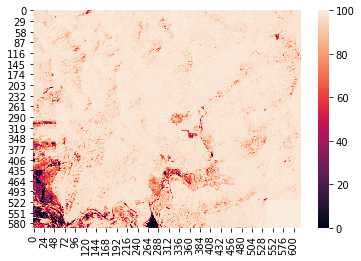

In [13]:
sns.heatmap(right, vmax = 100)